# **Importing**

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

# This import is used by the 2nd masking section to determine where the masks are
from scipy.signal import find_peaks



# File Upload

In [ ]:
# Upload your ECG data file to Colab
from google.colab import files
uploaded = files.upload()


# **Loading ecg data**

Data length: 3000


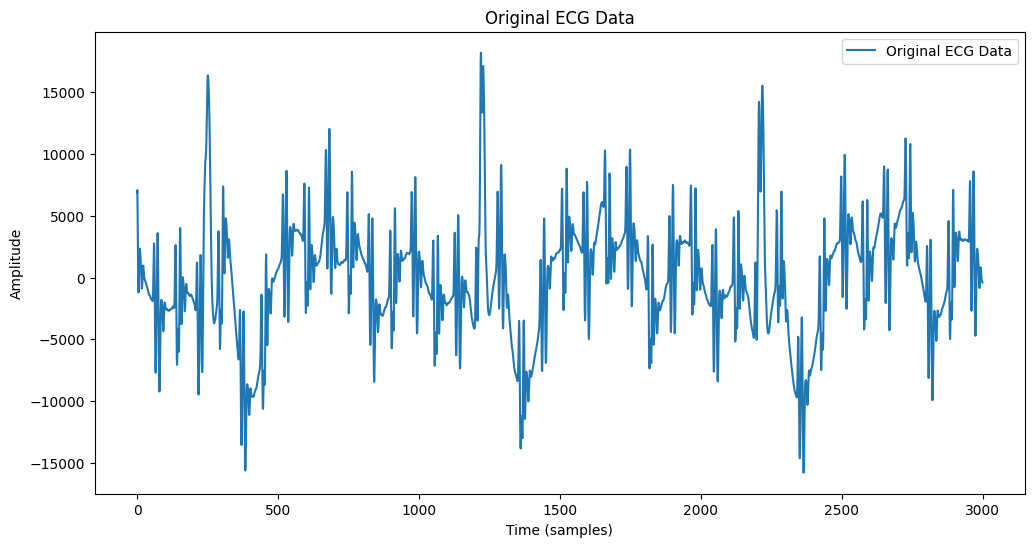

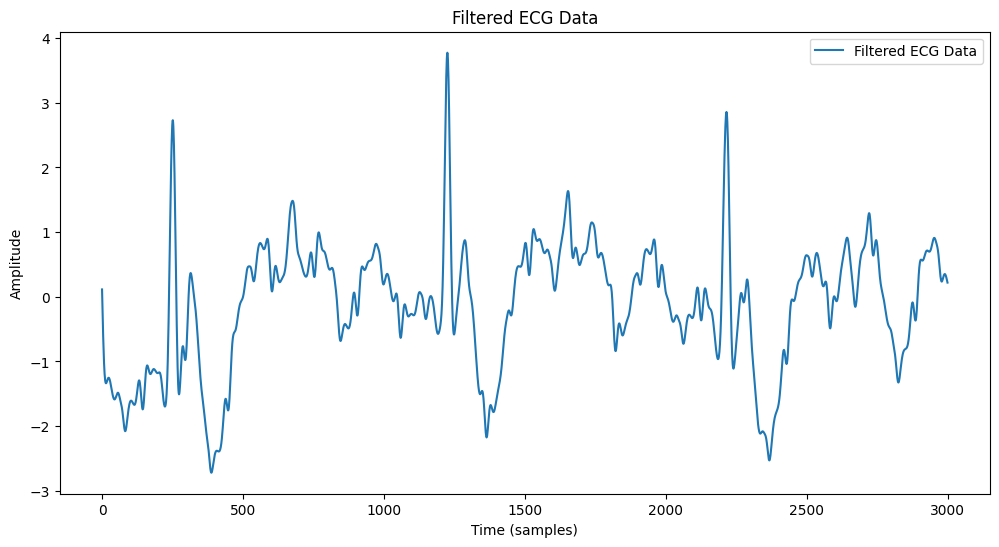

In [ ]:
# Function to load ECG data from a text file
def load_ecg_data(file_path, sampling_rate=1000, start_time=6*60+58, duration=30):
    """
    Load ECG data from a text file and extract a specific time window.

    Args:
        file_path (str): Path to the ECG data file.
        sampling_rate (int): Sampling rate of the ECG data.
        start_time (int): Start time in seconds for the time window.
        duration (int): Duration in seconds for the time window.

    Returns:
        np.array: Extracted ECG data.
    """
    # Read data from the file
    with open(file_path, 'r') as file:
        data = np.array([float(line.strip()) for line in file])

    # Calculate start and end indices for the time window
    start_index = int(start_time * sampling_rate)
    end_index = start_index + int(duration * sampling_rate)

    # Extract the time window data
    data = data[start_index:end_index]

    # Print the length of the data to confirm
    print(f"Data length: {len(data)}")

    # Check if data length is sufficient for filtering
    if len(data) <= 27:
        raise ValueError("Data length is insufficient for filtering. Increase the duration or check the sampling rate.")

    return data

# Function to normalize ECG data
def normalize_ecg(data):
    """
    Normalize ECG data to have zero mean and unit variance.

    Args:
        data (np.array): ECG data.

    Returns:
        np.array: Normalized ECG data.
    """
    return (data - np.mean(data)) / np.std(data)

# Function to apply bandpass filter
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=1000.0, order=4):
    """
    Apply a bandpass filter to the ECG data.

    Args:
        data (np.array): ECG data.
        lowcut (float): Low cutoff frequency.
        highcut (float): High cutoff frequency.
        fs (float): Sampling frequency.
        order (int): Order of the filter.

    Returns:
        np.array: Filtered ECG data.
    """
    nyquist = 0.5 * fs  # Calculate Nyquist frequency
    low = lowcut / nyquist  # Normalize low cutoff frequency
    high = highcut / nyquist  # Normalize high cutoff frequency
    b, a = butter(order, [low, high], btype='band')  # Design bandpass filter
    y = filtfilt(b, a, data)  # Apply filter to the data
    return y

# Path to the uploaded ECG data file
file_path = list(uploaded.keys())[1]

# Parameters for data extraction
sampling_rate = 1000  # Sampling rate of the ECG data
start_time = 6*60 + 58  # Start time for the time window (6 minutes and 58 seconds)
duration = 3  # Duration for the time window (3 seconds)

# Load, normalize, and filter the ECG data
ecg_data = load_ecg_data(file_path, sampling_rate, start_time, duration)
normalized_ecg = normalize_ecg(ecg_data)
filtered_ecg = bandpass_filter(normalized_ecg, lowcut=0.5, highcut=40.0, fs=sampling_rate)

# Reshape the data for model input
num_samples = len(filtered_ecg)  # Number of samples in the specified duration
num_leads = 1  # Single lead
filtered_ecg = filtered_ecg.reshape((1, num_samples, num_leads))


# Plot the original ECG data
plt.figure(figsize=(12, 6))
plt.plot(ecg_data, label='Original ECG Data')
plt.legend()
plt.title('Original ECG Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

# Plot the Filtered ECG data
plt.figure(figsize=(12, 6))
plt.plot(filtered_ecg.flatten(), label='Filtered ECG Data')
plt.legend()
plt.title('Filtered ECG Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

# **Masking Half of the data randomly**

In [ ]:
# Function to segment the data
def segment_data(data, segment_length):
    """
    Segment the data into smaller segments of fixed length.

    Args:
        data (np.array): Input data.
        segment_length (int): Length of each segment.

    Returns:
        np.array: Segmented data.
    """
    segments = [data[i:i + segment_length] for i in range(0, len(data), segment_length)]
    return np.array(segments)

# Function to mask half of the data
def mask_half_data(data):
    """
    Randomly mask half of the data.

    Args:
        data (np.array): Input data to be masked.

    Returns:
        np.array: Masked data.
        np.array: Mask indicating which parts were masked.
    """
    mask = np.random.rand(*data.shape) < 0.70  # Create a mask
    masked_data = np.copy(data)  # Copy the original data
    masked_data[mask] = 0  # Apply the mask to the data
    return masked_data, mask

# Segment the data into 1000-sample segments
segment_length = 1000
segmented_ecg = segment_data(filtered_ecg.flatten(), segment_length)

# Mask half of the data
masked_ecg, mask = mask_half_data(segmented_ecg)


Plotting the masked ecg data. It is clear that most of the plot is being set to 0.

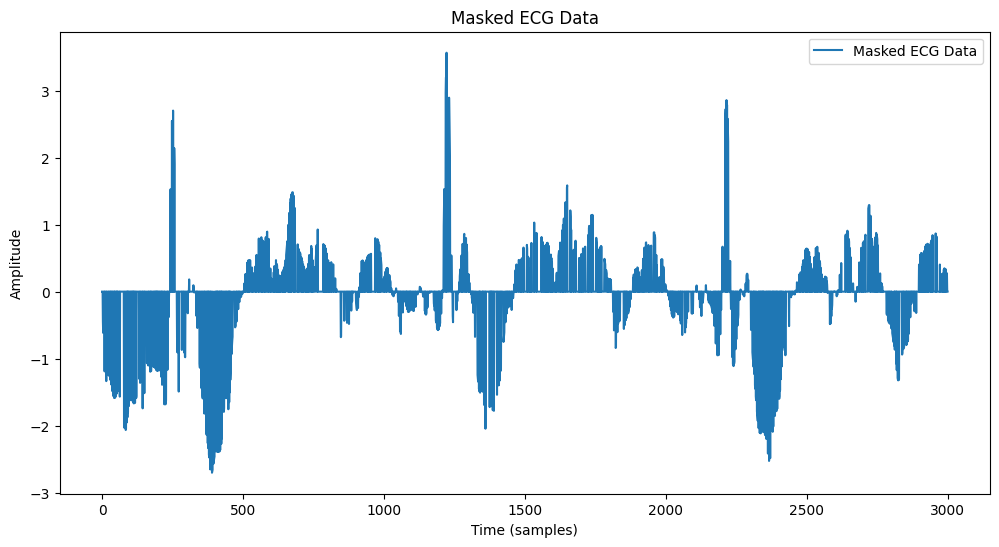

In [ ]:
# Plot the masked ECG data
plt.figure(figsize=(12, 6))
plt.plot(masked_ecg.flatten(), label='Masked ECG Data')
plt.legend()
plt.title('Masked ECG Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

# **Creating the Masked Autoencoder**

In [ ]:
# Define the masked autoencoder architecture
input_dim = segment_length  # Input dimension is the segment length
latent_dim = 50  # Latent dimension. I should increase this to inscrease the amount of data that can be encoded

# Encoder (adding layers using relu)
inputs = Input(shape=(input_dim,))  # Input layer
h = Dense(512, activation='relu')(inputs)  # Dense layer with ReLU activation
h = Dense(256, activation='relu')(h)  # Dense layer with ReLU activation
h = Dense(128, activation='relu')(h)  # Adding another layer
encoded = Dense(latent_dim, activation='relu')(h)  # Latent representation

# Decoder (adding layers using relu)
h_decoded = Dense(128, activation='relu')(encoded)  # Dense layer with ReLU activation
h_decoded = Dense(256, activation='relu')(h_decoded)
h_decoded = Dense(512, activation='relu')(h_decoded)  # Dense layer with ReLU activation
decoded = Dense(input_dim, activation='linear')(h_decoded)  # Output layer

# Masked autoencoder model
autoencoder = Model(inputs, decoded)  # Create the autoencoder model

# Loss function
def masked_loss(y_true, y_pred):
    """
    Custom loss function to calculate loss only on unmasked parts of the data.

    Args:
        y_true (tf.Tensor): True values.
        y_pred (tf.Tensor): Predicted values.

    Returns:
        tf.Tensor: Computed loss.
    """
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  # Create a mask
    return tf.reduce_sum(mask * tf.square(y_true - y_pred)) / tf.reduce_sum(mask)  # Compute masked loss


# Compile the autoencoder model with a learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss=masked_loss)


# **Training**

In [ ]:
# Flatten the data for training
flattened_ecg = segmented_ecg.reshape((-1, input_dim))

# Mask the data
masked_ecg, mask = mask_half_data(flattened_ecg)

# Train the masked autoencoder
autoencoder.fit(masked_ecg, flattened_ecg, epochs=190, batch_size=35)


Epoch 1/190
1/1 [==============================] - 2s 2s/step - loss: 0.9560
Epoch 2/190
1/1 [==============================] - 0s 26ms/step - loss: 0.9390
Epoch 3/190
1/1 [==============================] - 0s 22ms/step - loss: 0.8908
Epoch 4/190
1/1 [==============================] - 0s 21ms/step - loss: 0.7925
Epoch 5/190
1/1 [==============================] - 0s 22ms/step - loss: 0.6390
Epoch 6/190
1/1 [==============================] - 0s 21ms/step - loss: 0.5138
Epoch 7/190
1/1 [==============================] - 0s 24ms/step - loss: 0.5188
Epoch 8/190
1/1 [==============================] - 0s 21ms/step - loss: 0.3752
Epoch 9/190
1/1 [==============================] - 0s 29ms/step - loss: 0.2937
Epoch 10/190
1/1 [==============================] - 0s 22ms/step - loss: 0.2606
Epoch 11/190
1/1 [==============================] - 0s 22ms/step - loss: 0.2199
Epoch 12/190
1/1 [==============================] - 0s 20ms/step - loss: 0.1739
Epoch 13/190
1/1 [==============================] -

# **Reconstructing the signals after the masking**

In [ ]:
# Reconstruct the data
reconstructed_ecg = autoencoder.predict(flattened_ecg)
reconstructed_ecg = reconstructed_ecg.flatten()

# Calculate and print the error metrics
mse_error = mean_squared_error(flattened_ecg.flatten(), reconstructed_ecg.flatten())
mae_error = mean_absolute_error(flattened_ecg.flatten(), reconstructed_ecg.flatten())
print(f"Mean Squared Error: {mse_error}")
print(f"Mean Absolute Error: {mae_error}")


1/1 [==============================] - 0s 123ms/step
Mean Squared Error: 0.043634330796694355
Mean Absolute Error: 0.14448380455984916


# **Plotting the reconstructed data with the original data**

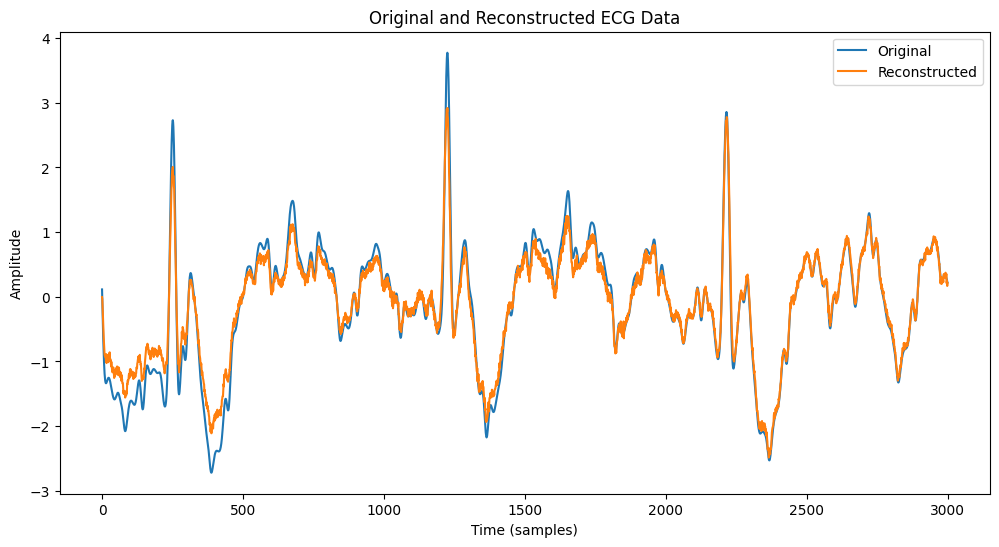

In [ ]:
# Plot the original and reconstructed ECG data
plt.figure(figsize=(12, 6))
plt.plot(flattened_ecg.flatten(), label='Original')
plt.plot(reconstructed_ecg, label='Reconstructed')
plt.legend()
plt.title('Original and Reconstructed ECG Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

# **Masking the peaks of the data**

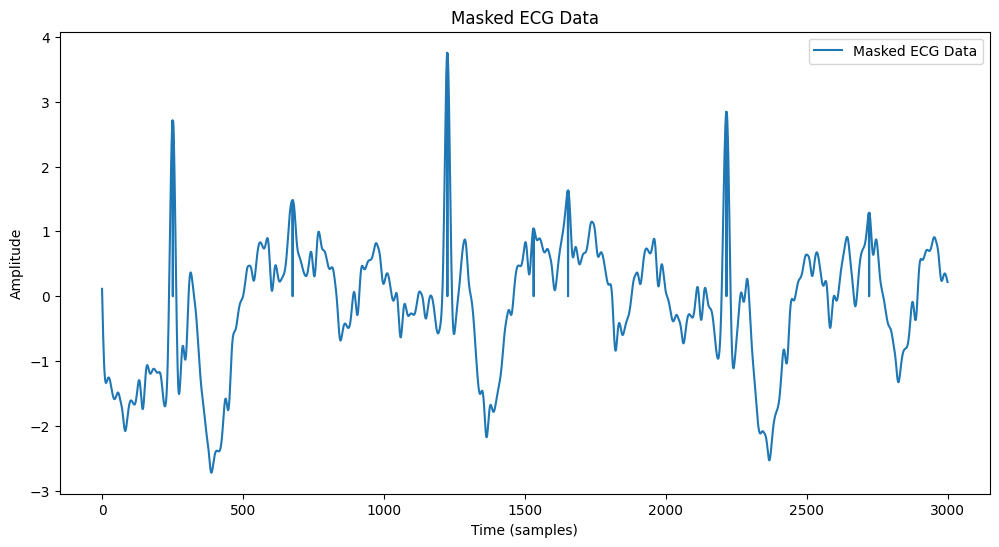

In [ ]:
# Function to segment the data
def segment_data(data, segment_length):
    """
    Segment the data into smaller segments of fixed length.

    Args:
        data (np.array): Input data.
        segment_length (int): Length of each segment.

    Returns:
        np.array: Segmented data.
    """
    segments = [data[i:i + segment_length] for i in range(0, len(data), segment_length)]
    return np.array(segments)

# Function to mask peaks in the data
def mask_peaks(data, height_threshold=-3, distance=100):
    """
    Mask peaks in the ECG data based on a height threshold.

    Args:
        data (np.array): Input ECG data.
        height_threshold (float): Height threshold for peak detection.
        distance (int): Minimum distance between peaks.

    Returns:
        np.array: Masked data.
        np.array: Mask indicating which parts were masked.
    """
    peaks, _ = find_peaks(data, height=height_threshold, distance=distance)  # Finding peak values
    mask = np.zeros_like(data, dtype=bool)
    mask[peaks] = True  # Create a mask for the peaks
    masked_data = np.copy(data)
    masked_data[mask] = 0  # Mask the peaks by setting them to zero
    return masked_data, mask

# Segment the data into 1000-sample segments
segment_length = 1000
segmented_ecg = segment_data(filtered_ecg.flatten(), segment_length)

# Mask peaks in the data
masked_ecg, mask = mask_peaks(segmented_ecg.flatten(), height_threshold=1.0)

# Reshape masked_ecg to its segmented form
masked_ecg = masked_ecg.reshape(segmented_ecg.shape)

# Plot the 2nd masked ECG data
plt.figure(figsize=(12, 6))
plt.plot(masked_ecg.flatten(), label='Masked ECG Data')
plt.legend()
plt.title('Masked ECG Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()


# **Training (masked peaks)**

In [ ]:
# Flatten the data for training
flattened_ecg = segmented_ecg.reshape((-1, input_dim))

# Mask the data
masked_ecg, mask = mask_half_data(flattened_ecg)

# Train the masked autoencoder
autoencoder.fit(masked_ecg, flattened_ecg, epochs=200, batch_size=35)


Epoch 1/200
1/1 [==============================] - 0s 28ms/step - loss: 0.4695
Epoch 2/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0919
Epoch 3/200
1/1 [==============================] - 0s 25ms/step - loss: 0.2118
Epoch 4/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0479
Epoch 5/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0324
Epoch 6/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0994
Epoch 7/200
1/1 [==============================] - 0s 33ms/step - loss: 0.0723
Epoch 8/200
1/1 [==============================] - 0s 36ms/step - loss: 0.0206
Epoch 9/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0247
Epoch 10/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0488
Epoch 11/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0210
Epoch 12/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0117
Epoch 13/200
1/1 [==============================]

# **Reconstructing the signals after the masking**

In [ ]:
# Reconstruct the data
reconstructed_ecg_peak = autoencoder.predict(flattened_ecg)
reconstructed_ecg_peak = reconstructed_ecg_peak.flatten()

# Calculate and print the error metrics
mse_error = mean_squared_error(flattened_ecg.flatten(), reconstructed_ecg_peak.flatten())
mae_error = mean_absolute_error(flattened_ecg.flatten(), reconstructed_ecg_peak.flatten())
print(f"Mean Squared Error: {mse_error}")
print(f"Mean Absolute Error: {mae_error}")


1/1 [==============================] - 0s 23ms/step
Mean Squared Error: 0.020317036194250654
Mean Absolute Error: 0.10594412482334947


# **Plotting Masked Peaks reconstructed plot with the original reconstructed plot and the filtered ecg plot**

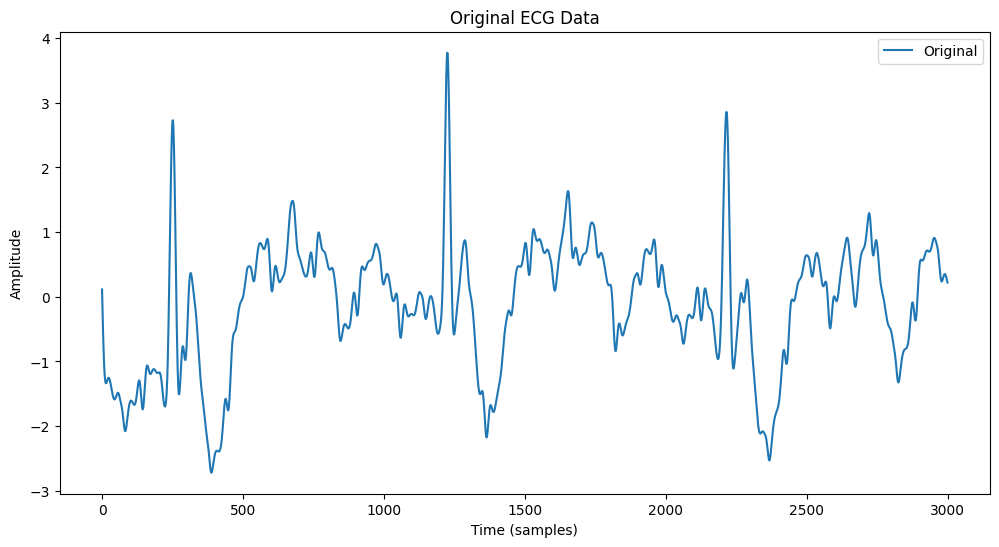

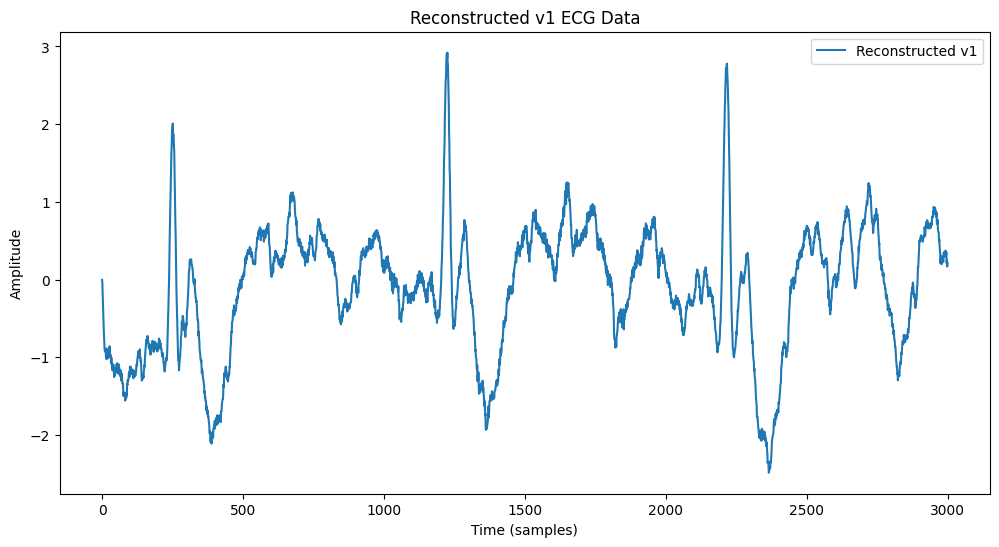

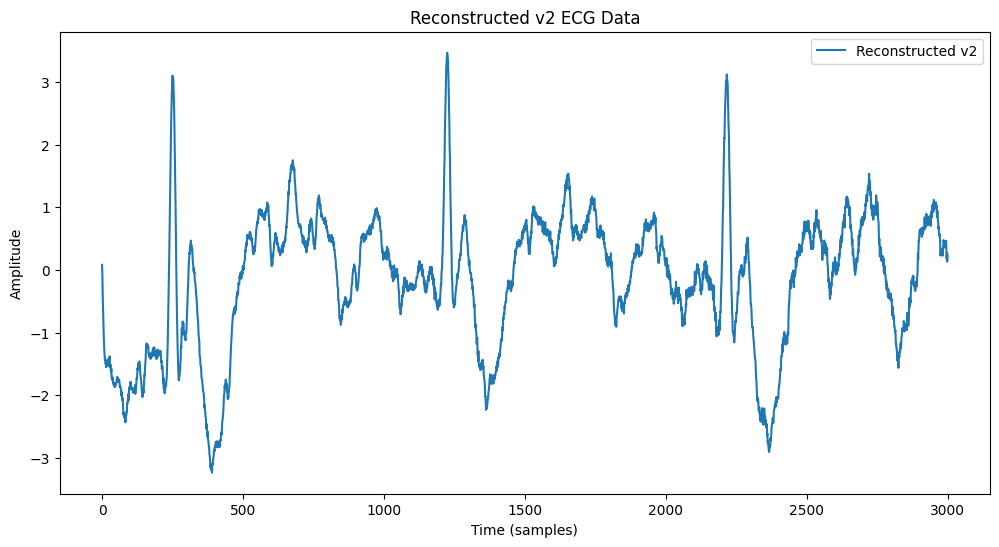

In [ ]:
# Plot the original and reconstructed ECG data
plt.figure(figsize=(12, 6))
plt.plot(flattened_ecg.flatten(), label='Original')
plt.legend()
plt.title('Original ECG Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(reconstructed_ecg, label='Reconstructed v1')
plt.legend()
plt.title('Reconstructed v1 ECG Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(reconstructed_ecg_peak, label='Reconstructed v2')
plt.legend()
plt.title('Reconstructed v2 ECG Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()